# Module 6: 分类 Classification


以下教程包含用于解决分类问题的Python示例。 可以从 http://www.cse.msu.edu/~ptan/dmbook/tutorials/tutorial6/tutorial6.ipynb 下载笔记本。

分类是根据其他属性（称为预测变量）的值预测标称值属性（称为类别标签）的任务。 本教程的目标如下：
1. 提供使用scikit-learn库包中的不同分类技术的示例。
2. 演示模型过度拟合的问题。

请仔细阅读下面的分步说明。 要执行代码，请单击相应的单元格，然后同时按SHIFT-ENTER键。


## 6.1 脊椎动物（Vertebrate）数据集

在脊椎动物数据中，根据一组解释性属性（预测变量），将每种脊椎动物分为5类中的一种：哺乳动物，爬行动物，鸟类，鱼类和两栖动物（mammals, reptiles, birds, fishes, and amphibians）。 除“名称”外，其余属性已转换为*独热编码（one-hot）*二进制表示形式。 为了说明这一点，我们将首先将数据加载到Pandas DataFrame对象中并显示其内容。

**<font color="red">代码：</font>**

**<font color ='red'>任务：</font>** 请尝试使用tutorial3中的方法对该数据进行探索。

In [1]:
import pandas as pd

data = pd.read_csv("vertebrate.csv", header="infer")
data

,Name,Warm-blooded,Gives Birth,Aquatic Creature,Aerial Creature,Has Legs,Hibernates,Class
0,human,1,1,0,0,1,0,mammals
1,python,0,0,0,0,0,1,reptiles
2,salmon,0,0,1,0,0,0,fishes
3,whale,1,1,1,0,0,0,mammals
4,frog,0,0,1,0,1,1,amphibians
5,komodo,0,0,0,0,1,0,reptiles
6,bat,1,1,0,1,1,1,mammals
7,pigeon,1,0,0,1,1,0,birds
8,cat,1,1,0,0,1,0,mammals
9,leopard shark,0,1,1,0,0,0,fishes


In [2]:
data.describe()

,Warm-blooded,Gives Birth,Aquatic Creature,Aerial Creature,Has Legs,Hibernates
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.466667,0.400000,0.533333,0.133333,0.666667,0.333333
std,0.516398,0.507093,0.516398,0.351866,0.487950,0.487950
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


给定有限数量的训练样例，假设我们将问题转换为二分类任务（哺乳动物与非哺乳动物，mammals versus non-mammals）。 我们可以通过将实例的类标签替换为 *非哺乳动物（non-mammals）* 来实现，但属于 *哺乳动物（mammals）* 类的训练样例不进行替换。

In [3]:
data["Class"] = data["Class"].replace(
    ["fishes", "birds", "amphibians", "reptiles"], "non-mammals"
)
data

,Name,Warm-blooded,Gives Birth,Aquatic Creature,Aerial Creature,Has Legs,Hibernates,Class
0,human,1,1,0,0,1,0,mammals
1,python,0,0,0,0,0,1,non-mammals
2,salmon,0,0,1,0,0,0,non-mammals
3,whale,1,1,1,0,0,0,mammals
4,frog,0,0,1,0,1,1,non-mammals
5,komodo,0,0,0,0,1,0,non-mammals
6,bat,1,1,0,1,1,1,mammals
7,pigeon,1,0,0,1,1,0,non-mammals
8,cat,1,1,0,0,1,0,mammals
9,leopard shark,0,1,1,0,0,0,non-mammals


我们可以使用 Pandas交叉表 来检查“Warm-blooded”和“Gives Birth”属性与类别标签（是否为哺乳动物）之间的关系。

**<font color ='red'>任务：</font>** 请尝试使用 Pandas交叉表 对其它属性（或者属性的组合）进行探索。


In [4]:
pd.crosstab([data["Warm-blooded"], data["Gives Birth"]], data["Class"])

Class                     mammals  non-mammals
Warm-blooded Gives Birth                      
0            0                  0            7
             1                  0            1
1            0                  0            2
             1                  5            0

上面的结果表明，仅使用这两个属性就可以将哺乳动物与非哺乳动物区分开，因为它们的属性值的每种组合只会产生属于同一类的实例。 例如，哺乳动物可以被识别为温血且胎生的脊椎动物。 这种关系也可以使用决策树分类器来推导，如下小节中的示例所示。

In [5]:
pd.crosstab([data["Aquatic Creature"], data["Aerial Creature"]], data["Has Legs"])

Has Legs                          0  1
Aquatic Creature Aerial Creature      
0                0                1  4
                 1                0  2
1                0                4  4

## 3.2 决策树分类器 Decision Tree Classifier

在本节中，我们将决策树分类器应用于前面小节中描述的脊椎动物数据集。


**<font color ='red'>任务：</font>** 
1. 请查阅sklearn文档，并尝试使用不同的“不纯度度量”策略训练决策树，并进行测试；使用不同的“最大深度”训练决策树，并进行测试。
2. 针对tutorial 3中的鸢尾花数据（iris.data）训练决策树并进行测试；可以将该数据的80%作为训练集，20%作为测试集。

**<font color ='red'>思考：</font>** 
1. 观察使用不同配置的决策树的运行结果并进行分析。
2. 观察决策树在鸢尾花数据上的表现并进行分析。


In [6]:
from sklearn import tree

Y = data["Class"]
# 从data中去掉Name和Class作为输入特征X
X = data.drop(["Name", "Class"], axis=1)

clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf = clf.fit(X, Y)

前面的命令将从脊椎动物数据集中提取预测变量（X）和目标类别（Y）属性，并使用熵作为分裂标准的不纯度度量（impurity measure）来创建决策树分类器。 Python sklearn库中的决策树类还支持使用 “gini” 作为不纯度度量。 上面的决策树分类器的最大深度被限制为3。接下来，使用fit()函数在标记的数据上训练分类器。

我们可以绘制训练分类器后获得的结果决策树。 为此，
1. 必须先下载安装 graphviz可执行文件（http://www.graphviz.org ），注意，这里需要配置环境变量，并在管理员权限运行的命令行下执行“dot -c”（因为在windows平台上，graphviz插件在使用之前需要注册）；

2. 安装Python界面包 pydotplus （http://pydotplus.readthedocs.io/ ） 。

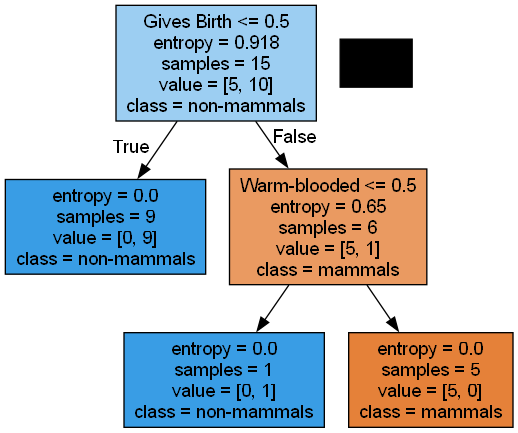

In [7]:
import pydotplus
from IPython.display import Image

dot_data = tree.export_graphviz(
    clf,
    feature_names=X.columns,
    class_names=["mammals", "non-mammals"],
    filled=True,
    out_file=None,
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

接下来，我们使用决策树对以下测试示例进行分类。

In [8]:
testData = [
    ["gila monster", 0, 0, 0, 0, 1, 1, "non-mammals"],
    ["platypus", 1, 0, 0, 0, 1, 1, "mammals"],
    ["owl", 1, 0, 0, 1, 1, 0, "non-mammals"],
    ["dolphin", 1, 1, 1, 0, 0, 0, "mammals"],
]
testData = pd.DataFrame(testData, columns=data.columns)
testData

,Name,Warm-blooded,Gives Birth,Aquatic Creature,Aerial Creature,Has Legs,Hibernates,Class
0,gila monster,0,0,0,0,1,1,non-mammals
1,platypus,1,0,0,0,1,1,mammals
2,owl,1,0,0,1,1,0,non-mammals
3,dolphin,1,1,1,0,0,0,mammals


我们首先从测试数据中提取预测变量和目标类别属性，然后应用决策树分类器预测其类别。

In [9]:
testY = testData["Class"]
testX = testData.drop(["Name", "Class"], axis=1)

predY = clf.predict(testX)
predictions = pd.concat(
    [testData["Name"], pd.Series(predY, name="Predicted Class")], axis=1
)
predictions

,Name,Predicted Class
0,gila monster,non-mammals
1,platypus,non-mammals
2,owl,non-mammals
3,dolphin,mammals


除了鸭嘴兽（platypus）是卵生哺乳动物外，分类器可以正确预测测试示例的类别标签。 我们可以根据测试数据的结果计算分类器的准确性，如下例所示。

In [10]:
from sklearn.metrics import accuracy_score

print("Accuracy on test data is %.2f" % (accuracy_score(testY, predY)))

Accuracy on test data is 0.75


### 3.2.1. 任务

In [11]:
iris_data = pd.read_csv("iris.csv", header="infer")
iris_data

,sepal_l,sepal_w,petal_l,petal_w,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [12]:
from sklearn.model_selection import train_test_split

X = iris_data.drop(["species"], axis=1)
Y = iris_data["species"]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0x0D000721
)

clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3)
clf = clf.fit(X_train, Y_train)

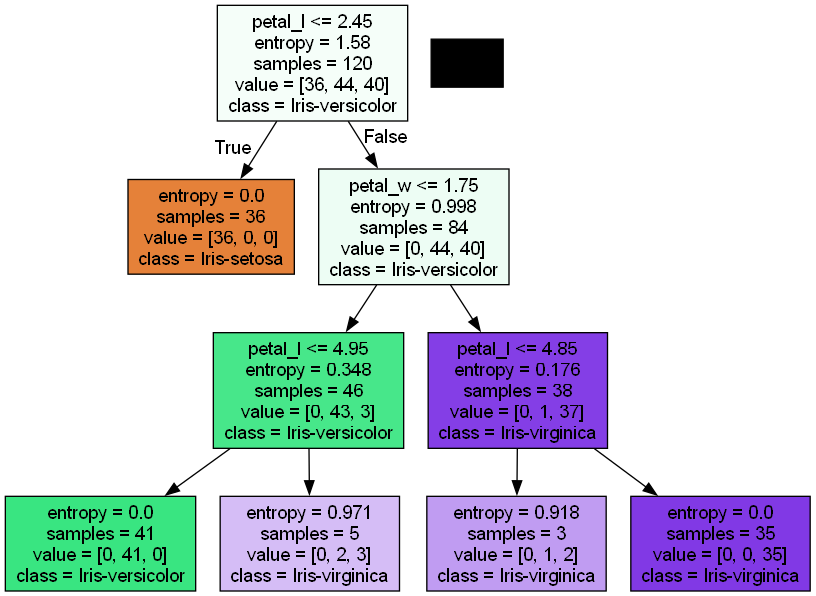

In [13]:
dot_data = tree.export_graphviz(
    clf,
    feature_names=X_train.columns,
    class_names=["Iris-setosa", "Iris-versicolor", "Iris-virginica"],
    filled=True,
    out_file=None,
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [14]:
Y_pred = clf.predict(X_test)
print("Accuracy on test data is %.2f" % (accuracy_score(Y_test, Y_pred)))

Accuracy on test data is 0.97


In [15]:
for depth in range(1, 10 + 1):
    clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=depth)
    clf = clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    print(f"depth={depth} acc={accuracy_score(Y_test, Y_pred)}")

depth=1 acc=0.6666666666666666
depth=2 acc=0.9333333333333333
depth=3 acc=0.9666666666666667
depth=4 acc=0.9333333333333333
depth=5 acc=0.9333333333333333
depth=6 acc=0.9666666666666667
depth=7 acc=0.9333333333333333
depth=8 acc=0.9333333333333333
depth=9 acc=0.9666666666666667
depth=10 acc=0.9333333333333333


## 3.3 模型过拟合 Model Overfitting

为了说明模型过度拟合的问题，我们考虑一个二维数据集，其中包含1500个带类别标签（class label）的实例，每个实例被分配给两个类别（0或1）中的一个。每个类别的实例生成如下：

1. 来自类别1的实例是由3个高斯分布的混合生成的，其中，这三个高斯分布分别以[6,14]，[10,6]和[14 14]为中心。
2. 来自类别0的实例由正方形区域中的均匀分布生成，该正方形区域的边长等于20。

为简单起见，两个类都具有相等数量的标记实例。 生成和绘制数据的代码如下所示。 来自类别1的所有实例均以红色显示，而来自类别0的所有实例均以黑色显示。

**<font color ='red'>任务：</font>** 
1. 尝试增加样本数据，然后运行模型。
2. 请查阅numpy文档，并尝试使用其它的数据分布构造测试和训练样例，然后运行算法。

**<font color ='red'>思考：</font>**  
1. 观察不同规模的测试数据对决策树的过拟合情况是否有影响，如果有，请分析其规律。
2. 观察决策树在使用其它数据分布构造的数据集上的表现并进行分析。


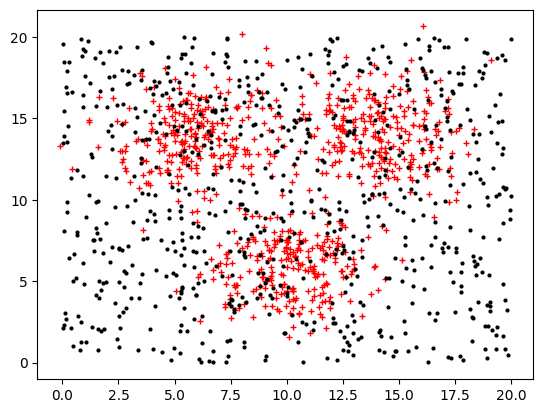

In [16]:
import numpy as np
import matplotlib.pyplot as plt

N = 1500

mean1 = [6, 14]
mean2 = [10, 6]
mean3 = [14, 14]
cov = [[3.5, 0], [0, 3.5]]  # diagonal covariance

np.random.seed(0x0D000721)
X = np.random.multivariate_normal(mean1, cov, int(N / 6))
X = np.concatenate((X, np.random.multivariate_normal(mean2, cov, int(N / 6))))
X = np.concatenate((X, np.random.multivariate_normal(mean3, cov, int(N / 6))))
X = np.concatenate((X, 20 * np.random.rand(int(N / 2), 2)))
Y = np.concatenate((np.ones(int(N / 2)), np.zeros(int(N / 2))))

plt.plot(
    X[: int(N / 2), 0],
    X[: int(N / 2), 1],
    "r+",
    X[int(N / 2) :, 0],
    X[int(N / 2) :, 1],
    "k.",
    ms=4,
)

plt.show()

在此示例中，我们保留了80％的数据用于训练，其余20％的数据用于测试。 然后，我们将使用具有不同最大深度（从2到50）的决策树拟合训练集，并将其在测试集上的精度绘制出来。

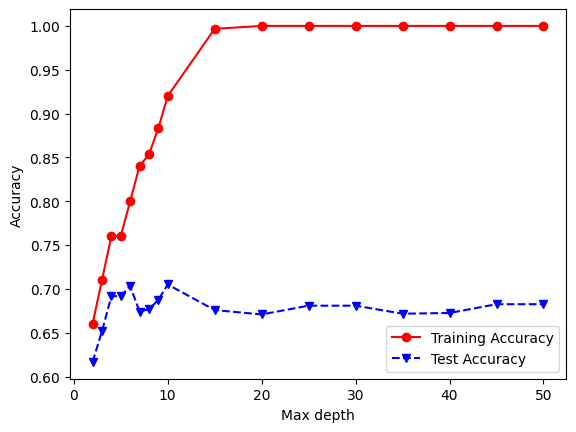

In [17]:
#########################################
# Training and Test set creation
#########################################

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=1)

from sklearn import tree
from sklearn.metrics import accuracy_score

#########################################
# Model fitting and evaluation
#########################################

maxdepths = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50]

trainAcc = np.zeros(len(maxdepths))
testAcc = np.zeros(len(maxdepths))

index = 0
for depth in maxdepths:
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(X_train, Y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predTest = clf.predict(X_test)
    trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
    testAcc[index] = accuracy_score(Y_test, Y_predTest)
    index += 1

#########################################
# Plot of training and test accuracies
#########################################

plt.plot(maxdepths, trainAcc, "ro-", maxdepths, testAcc, "bv--")
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Max depth")
plt.ylabel("Accuracy")

plt.show()

上图显示随着决策树的最大深度增加（即模型变得更加复杂），训练精度将继续提高。 但是，测试精度最初会提高，但最大深度超过5之后模型会过度拟合而导致测试精度逐渐降低。

### 3.3.1. 任务

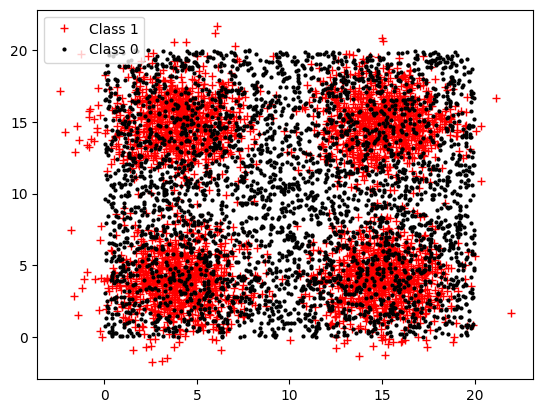

In [18]:
N = 7000

mean1 = [4, 15]
mean2 = [15, 15]
mean3 = [15, 4]
mean4 = [4, 4]
cov = [[3.5, 0], [0, 3.5]]  # diagonal covariance

np.random.seed(0x0D000721)
X = np.concatenate(
    (
        np.random.multivariate_normal(mean1, cov, N // 8),
        np.random.multivariate_normal(mean2, cov, N // 8),
        np.random.multivariate_normal(mean3, cov, N // 8),
        np.random.multivariate_normal(mean4, cov, N // 8),
        20 * np.random.rand(N // 2, 2),
    )
)
Y = np.concatenate((np.ones(N // 2), np.zeros(N // 2)))

plt.plot(X[Y == 1, 0], X[Y == 1, 1], "r+", label="Class 1")
plt.plot(X[Y == 0, 0], X[Y == 0, 1], "k.", label="Class 0", ms=4)
plt.legend()
plt.show()

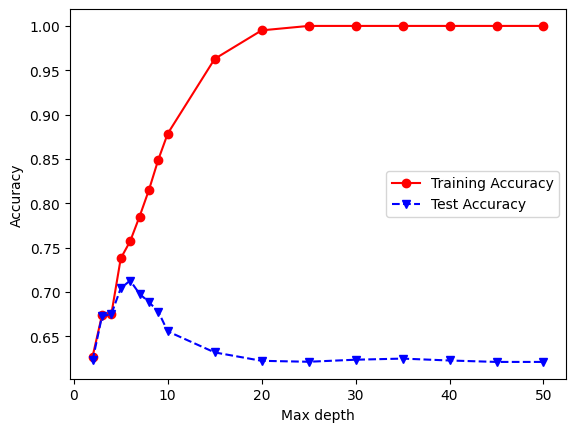

In [19]:
#########################################
# Training and Test set creation
#########################################

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=1)

#########################################
# Model fitting and evaluation
#########################################

maxdepths = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50]

trainAcc = np.zeros(len(maxdepths))
testAcc = np.zeros(len(maxdepths))

index = 0
for depth in maxdepths:
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(X_train, Y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predTest = clf.predict(X_test)
    trainAcc[index] = accuracy_score(Y_train, Y_predTrain)
    testAcc[index] = accuracy_score(Y_test, Y_predTest)
    index += 1

#########################################
# Plot of training and test accuracies
#########################################

plt.plot(maxdepths, trainAcc, "ro-", maxdepths, testAcc, "bv--")
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Max depth")
plt.ylabel("Accuracy")

plt.show()

## 3.4 其他分类技术 Alternative Classification Techniques

Besides decision tree classifier, the Python sklearn library also supports other classification techniques. In this section, we provide examples to illustrate how to apply the k-nearest neighbor classifier, linear classifiers (logistic regression and support vector machine), as well as ensemble methods (boosting, bagging, and random forest) to the 2-dimensional data given in the previous section.

除决策树分类器外，Python sklearn库还支持其他分类技术。 在本节中，我们提供示例来说明如何将k最近邻分类器、线性分类器（逻辑回归和支持向量机）以及集成方法（增强boosting，装袋bagging和随机森林random forest）应用于上一节的二维数据上。


### 3.4.1 K最近邻分类器 K-Nearest neighbor classifier

在这种方法中，将基于与测试实例最接近的 *k* 个训练实例的多数类来预测其实例标签。 最近邻居的数量 *k* 以及距离度量策略是用户必须提供的超参数。默认情况下，我们可以使用欧几里得距离（它等价于指数因子p=2的Minkowski距离）：

\begin{equation*}
\textrm{Minkowski distance}(x,y) = \bigg[\sum_{i=1}^N |x_i-y_i|^p \bigg]^{\frac{1}{p}}
\end{equation*}

**<font color ='red'>思考：</font>** 观察并分析 *k* 与训练和测试误差的关系。

Text(0, 0.5, 'Accuracy')

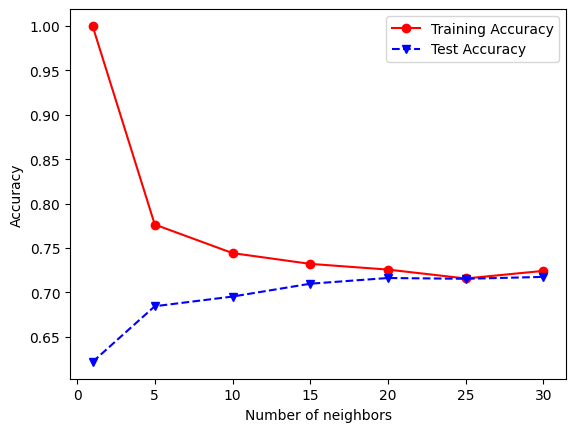

In [20]:
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

numNeighbors = [1, 5, 10, 15, 20, 25, 30]
trainAcc = []
testAcc = []

for k in numNeighbors:
    clf = KNeighborsClassifier(n_neighbors=k, metric="minkowski", p=2)
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predTest = clf.predict(X_test)
    trainAcc.append(accuracy_score(Y_train, Y_predTrain))
    testAcc.append(accuracy_score(Y_test, Y_predTest))

plt.plot(numNeighbors, trainAcc, "ro-", numNeighbors, testAcc, "bv--")
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")

### 3.4.2 线性分类器 Linear Classifiers

包括例如逻辑回归和支持向量机（SVM）线性分类器构造了一个线性分离超平面，以区分实例的不同类别。

对于逻辑回归，可以用以下方程式描述模型：
\begin{equation*}
P(y=1|x) = \frac{1}{1 + \exp^{-w^Tx - b}} = \sigma(w^Tx + b)
\end{equation*}
通过优化以下正则对数似然函数（regularized negative log-likelihood function）来估计模型参数 (w,b):
\begin{equation*}
(w^*,b^*) = \arg\min_{w,b} - \sum_{i=1}^N y_i \log\bigg[\sigma(w^Tx_i + b)\bigg] + (1-y_i) \log\bigg[\sigma(-w^Tx_i - b)\bigg] + \frac{1}{C} \Omega([w,b])
\end{equation*}
其中 $C$ 是控制模型复杂度的倒数的超参数（较小的值表示较强的正则化），而 $\Omega(\cdot)$ 是正则化项，在sklearn中默认为$l_2$-norm。

对于支持向量机，通过解决以下约束优化问题来估算模型参数$(w^*,b^*)$：
\begin{align*}
& \min_{w^*,b^*,\{\xi_i\}} \frac{\|w\|^2}{2} + \frac{1}{C} \sum_i \xi_i \\
\textrm{s.t.}\ & \forall i: y_i\bigg[w^T \phi(x_i) + b\bigg] \ge 1 - \xi_i, \ \ \xi_i \ge 0  
\end{align*}

**<font color ='red'>思考：</font>** 观察并尝试分析分类结果
1. 观察结果
2. 分析原因
3. 得出结论


Text(0, 0.5, 'Accuracy')

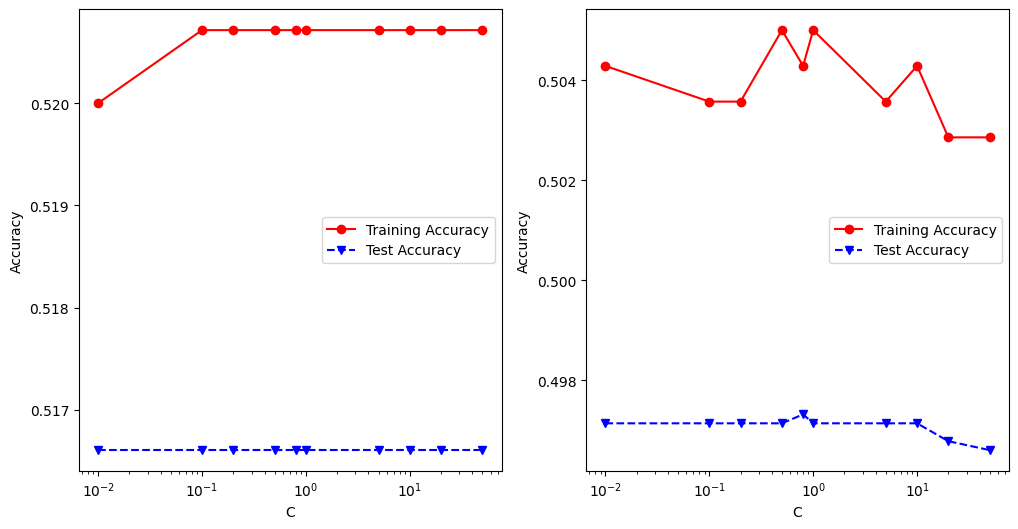

In [21]:
from sklearn import linear_model
from sklearn.svm import SVC

C = [0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10, 20, 50]
LRtrainAcc = []
LRtestAcc = []
SVMtrainAcc = []
SVMtestAcc = []

for param in C:
    clf = linear_model.LogisticRegression(C=param)
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predTest = clf.predict(X_test)
    LRtrainAcc.append(accuracy_score(Y_train, Y_predTrain))
    LRtestAcc.append(accuracy_score(Y_test, Y_predTest))

    clf = SVC(C=param, kernel="linear")
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predTest = clf.predict(X_test)
    SVMtrainAcc.append(accuracy_score(Y_train, Y_predTrain))
    SVMtestAcc.append(accuracy_score(Y_test, Y_predTest))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(C, LRtrainAcc, "ro-", C, LRtestAcc, "bv--")
ax1.legend(["Training Accuracy", "Test Accuracy"])
ax1.set_xlabel("C")
ax1.set_xscale("log")
ax1.set_ylabel("Accuracy")

ax2.plot(C, SVMtrainAcc, "ro-", C, SVMtestAcc, "bv--")
ax2.legend(["Training Accuracy", "Test Accuracy"])
ax2.set_xlabel("C")
ax2.set_xscale("log")
ax2.set_ylabel("Accuracy")

### 3.4.3 非线性支持向量机 Nonlinear Support Vector Machine

下面的代码显示了使用带有高斯径向基函数核（Gaussian radial basis function kernel）的非线性支持向量机来拟合二维数据集的示例。

**<font color ='red'>思考：</font>** 比较SVM和Nonlinear SVM，并分析其特点

Text(0, 0.5, 'Accuracy')

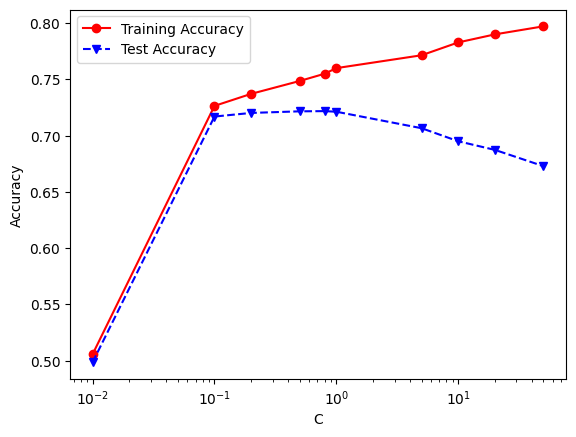

In [22]:
from sklearn.svm import SVC

C = [0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10, 20, 50]
SVMtrainAcc = []
SVMtestAcc = []

for param in C:
    clf = SVC(C=param, kernel="rbf", gamma="auto")
    clf.fit(X_train, Y_train)
    Y_predTrain = clf.predict(X_train)
    Y_predTest = clf.predict(X_test)
    SVMtrainAcc.append(accuracy_score(Y_train, Y_predTrain))
    SVMtestAcc.append(accuracy_score(Y_test, Y_predTest))

plt.plot(C, SVMtrainAcc, "ro-", C, SVMtestAcc, "bv--")
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("C")
plt.xscale("log")
plt.ylabel("Accuracy")

### 3.4.4 集成方法 Ensemble Methods


集成分类器根据训练数据构建一组基础分类器，并通过对每个基础分类器做出的预测进行投票来执行分类。 在此示例中，我们考虑了三种集成分类器：装袋（bagging）、增强（boosting）和随机森林（random forest）。 

在下面的示例中，我们使用每种集成方法将500个基本分类器拟合到二维数据集。 基本分类器是一个最大深度为10的决策树。


**<font color ='red'>思考：</font>** 通过查阅资料，学习三种集成方法，并对比分析其异同。

[Text(1.5, 0, 'Random Forest'),
 Text(2.5, 0, 'Bagging'),
 Text(3.5, 0, 'AdaBoost')]

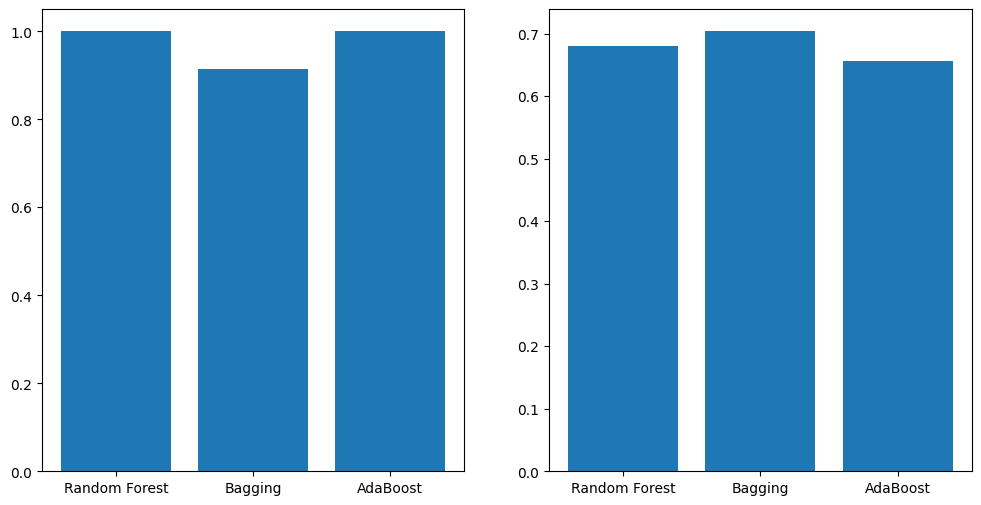

In [23]:
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier

numBaseClassifiers = 500
maxdepth = 10
trainAcc = []
testAcc = []

clf = ensemble.RandomForestClassifier(n_estimators=numBaseClassifiers)
clf.fit(X_train, Y_train)
Y_predTrain = clf.predict(X_train)
Y_predTest = clf.predict(X_test)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
testAcc.append(accuracy_score(Y_test, Y_predTest))

clf = ensemble.BaggingClassifier(
    DecisionTreeClassifier(max_depth=maxdepth), n_estimators=numBaseClassifiers
)
clf.fit(X_train, Y_train)
Y_predTrain = clf.predict(X_train)
Y_predTest = clf.predict(X_test)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
testAcc.append(accuracy_score(Y_test, Y_predTest))

clf = ensemble.AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=maxdepth), n_estimators=numBaseClassifiers
)
clf.fit(X_train, Y_train)
Y_predTrain = clf.predict(X_train)
Y_predTest = clf.predict(X_test)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
testAcc.append(accuracy_score(Y_test, Y_predTest))

methods = ["Random Forest", "Bagging", "AdaBoost"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.bar([1.5, 2.5, 3.5], trainAcc)
ax1.set_xticks([1.5, 2.5, 3.5])
ax1.set_xticklabels(methods)
ax2.bar([1.5, 2.5, 3.5], testAcc)
ax2.set_xticks([1.5, 2.5, 3.5])
ax2.set_xticklabels(methods)

## 3.5 总结 Summary

本节提供了几个使用Python sklearn库从给定输入数据构建分类模型的示例。 我们还说明了模型过度拟合的问题，并给出了将不同的分类方法应用于给定的数据集的代码。